# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
# from scipy.misc import imread, imresize
import datetime
import os
from imageio import imread
from skimage.transform import resize
import matplotlib.pyplot as plt 

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
# train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
# val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

train_doc = np.random.permutation(open('train.csv').readlines())
val_doc = np.random.permutation(open('val.csv').readlines())

batch_size = 10 #experiment with the batch size

### Normalize Image

In [4]:
import cv2 as cv 

def normalize_img(img):
#     normimg = cv.normalize(img, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
    normimg = img/255.0
    return normimg

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0, 30,2)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            x = len(img_idx)
            y = 120
            z = 120
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            ct_img=0
#             print("batch: ",batch)
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                ct_img+=1
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image_resized=resize(image, (120,120), mode='reflect')
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#             print("\nbatch:", batch," ct_img: ",ct_img, "path:", source_path)
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        ct_img=0
        batch_cover = num_batches*batch_size
        rem = len(t) - batch_cover
        if(len(t)!=batch_cover):
            for folder in range(rem):
                imgs = os.listdir(source_path+'/'+ t[folder + batch_cover].split(';')[0]) # read all the images in the folder
                ct_img+=1
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + batch_cover].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image_resized=resize(image, (120,120), mode='reflect')
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + batch_size].strip().split(';')[2])] = 1
#             print("\nbatchlast:", batch," ct_imglast: ",ct_img, "pathlast:", source_path)
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
                


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'
train_path = 'train/'
val_path = 'val/'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Function for buildmodel

In [7]:
# Function to build mode
def buildmodel(model,epochsize,batchsize, optimiser, lr):
    
    # Set batch size and epoch
    batch_size = batchsize #experiment with the batch size
    num_epochs = epochsize # choose the number of epochs
    
    # Optimizer and compile
    from keras.optimizers import Adam
    if(optimiser=="Adam"):
        optimiser = Adam(lr) #write your optimizer
    elif(optimiser=="sgd"):
        optimiser="sgd"
        
    
    # Now that you have written the model, the next step is to `compile` the model. 
    # When you print the `summary` of the model, you'll see the total number of parameters you have to train.
    
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    
    # Create Generators
    # Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)
    
    # Save h5 files
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    # write the REducelronplateau code here
#     LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001) 
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001) 
    
    callbacks_list = [checkpoint, LR]
    
    # The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() 
    # calls it need to make.
    # Epoch Calculation
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    # Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save 
    # the model at the end of each epoch.
    # Build Model
    model1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
    import matplotlib.pyplot as plt 
    # visualise training history
    plt.plot(model1.history['categorical_accuracy'])
    plt.plot(model1.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc="lower right")
    plt.show()

    # summarize history for loss
    plt.plot(model1.history['loss'])
    plt.plot(model1.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    return model1

### Conv2D + RNN Models

#### Import libraries

In [8]:
# Import libraries for building model
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.regularizers import l2

#### Model1 - Conv2D layers + GRU Layer + No dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 15, 15, 64)    18496     
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


67/67 [==============================] - 61s 909ms/step - loss: 1.2985 - categorical_accuracy: 0.4433 - val_loss: 1.0828 - val_categorical_accuracy: 0.6000

Epoch 00001: saving model to model_init_2020-05-2304_57_41.678187/model-00001-1.29854-0.44328-1.08277-0.60000.h5
Epoch 2/10
67/67 [==============================] - 60s 891ms/step - loss: 0.9444 - categorical_accuracy: 0.6149 - val_loss: 0.9373 - val_categorical_accuracy: 0.6200

Epoch 00002: saving model to model_init_2020-05-2304_57_41.678187/model-00002-0.94442-0.61493-0.93725-0.62000.h5
Epoch 3/10
67/67 [==============================] - 63s 936ms/step - loss: 0.8373 - categorical_accuracy: 0.6836 - val_loss: 1.0681 - val_categorical_accuracy: 0.5500

Epoch 00003: saving model to model_init_2020-05-2304_57_41.678187/model-00003-0.83734-0.68358-1.06805-0.55000.h5
Epoch 4/10
67/67 [==============================] - 58s 860ms/step - loss: 0.6252 - categorical_accuracy: 0.7627 - val_loss: 1.4393 - val_categorical_accuracy: 0.5600



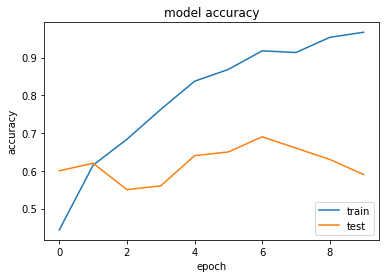

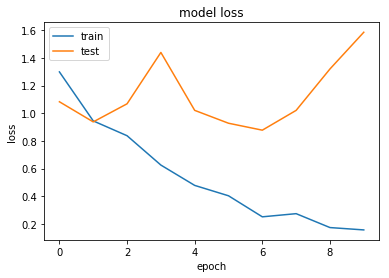

In [9]:
# Model1

# Features
batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,32,5]
dropout = 0.25
nb_classes = 5
frames = 15

# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dense(nb_dense[2], activation='relu'))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(64, return_sequences=False))

model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model1 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

Observation: <br>
1) Clear indication of overfitting. The training accuracy is 0.9672  where as validation accuracy is 0.5900 <br>
2) We will introduce batch normalization and dropouts to handle this

#### Model2 - Conv2D layers + GRU Layer +  dropout 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 15, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 30, 30, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 15, 15, 32)    0         
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


67/67 [==============================] - 71s 1s/step - loss: 1.4132 - categorical_accuracy: 0.3507 - val_loss: 1.4016 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_init_2020-05-2304_57_41.678187/model-00001-1.41320-0.35075-1.40162-0.43000.h5
Epoch 2/10
67/67 [==============================] - 57s 846ms/step - loss: 1.2003 - categorical_accuracy: 0.4761 - val_loss: 1.3809 - val_categorical_accuracy: 0.4900

Epoch 00002: saving model to model_init_2020-05-2304_57_41.678187/model-00002-1.20029-0.47612-1.38093-0.49000.h5
Epoch 3/10
67/67 [==============================] - 68s 1s/step - loss: 1.1633 - categorical_accuracy: 0.5224 - val_loss: 1.3333 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2020-05-2304_57_41.678187/model-00003-1.16326-0.52239-1.33325-0.50000.h5
Epoch 4/10
67/67 [==============================] - 56s 839ms/step - loss: 1.0168 - categorical_accuracy: 0.5746 - val_loss: 1.2414 - val_categorical_accuracy: 0.5000

Epoch 

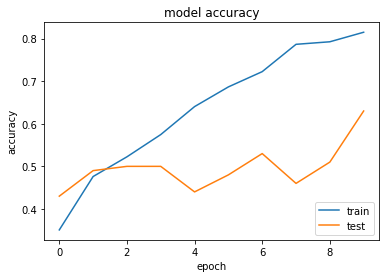

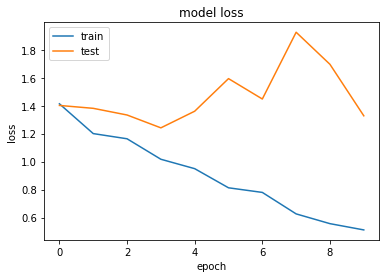

In [10]:
# Model2

# Features
batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,32,5]
dropout = 0.25
nb_classes = 5
frames = 15

# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Flatten()))

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dense(nb_dense[2], activation='relu'))
model.add(Dropout(dropout))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model2 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

Observation: <br>
1) This model is still overfitting. The training accuracy is 0.8149 where as validation accuracy is 0.6300 <br>
2) We will introduce L2 regularization

#### Model3 - Conv2D layers + GRU Layer +  dropout  + L2 regularization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_27 (TimeDis (None, 15, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_28 (TimeDis (None, 15, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_29 (TimeDis (None, 15, 30, 30, 16)    0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 15, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_31 (TimeDis (None, 15, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_32 (TimeDis (None, 15, 15, 15, 32)    0         
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


67/67 [==============================] - 71s 1s/step - loss: 4.5299 - categorical_accuracy: 0.3254 - val_loss: 3.6101 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2020-05-2304_57_41.678187/model-00001-4.52986-0.32537-3.61007-0.55000.h5
Epoch 2/10
67/67 [==============================] - 63s 945ms/step - loss: 3.1997 - categorical_accuracy: 0.4687 - val_loss: 2.7905 - val_categorical_accuracy: 0.4800

Epoch 00002: saving model to model_init_2020-05-2304_57_41.678187/model-00002-3.19974-0.46866-2.79046-0.48000.h5
Epoch 3/10
67/67 [==============================] - 63s 945ms/step - loss: 2.4339 - categorical_accuracy: 0.5522 - val_loss: 2.3477 - val_categorical_accuracy: 0.4600

Epoch 00003: saving model to model_init_2020-05-2304_57_41.678187/model-00003-2.43387-0.55224-2.34766-0.46000.h5
Epoch 4/10
67/67 [==============================] - 57s 851ms/step - loss: 1.9660 - categorical_accuracy: 0.5687 - val_loss: 1.7844 - val_categorical_accuracy: 0.5900

Epo

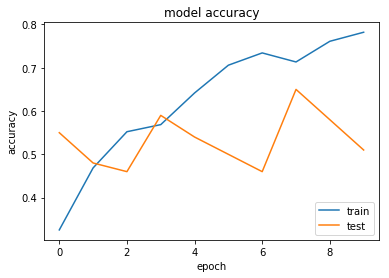

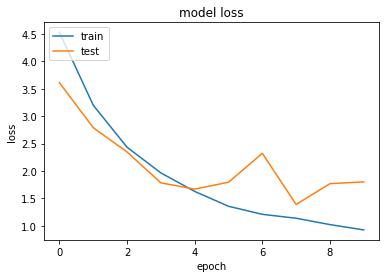

In [11]:
# Model3

# Features
batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,32,5]
dropout = 0.25
nb_classes = 5
frames = 15

# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Flatten()))

model.add(Dense(nb_dense[0], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(nb_dense[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(nb_dense[2], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(dropout))

## using GRU as the RNN model along with softmax as our last layer.
model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model3 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

Observation: <br>
1) This model is still overfitting. The training accuracy is 0.7821 where as validation accuracy is 0.5100 <br>
2) We will introduce L2 regularization

#### Model4 - Conv2D layers + LSTM Layer +  dropout  + L2 regularization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_40 (TimeDis (None, 15, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_41 (TimeDis (None, 15, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_42 (TimeDis (None, 15, 30, 30, 16)    0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_43 (TimeDis (None, 15, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_44 (TimeDis (None, 15, 30, 30, 32)    128       
_________________________________________________________________
time_distributed_45 (TimeDis (None, 15, 15, 15, 32)    0         
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


67/67 [==============================] - 73s 1s/step - loss: 4.2370 - categorical_accuracy: 0.3657 - val_loss: 3.3198 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2020-05-2304_57_41.678187/model-00001-4.23704-0.36567-3.31977-0.46000.h5
Epoch 2/10
67/67 [==============================] - 66s 980ms/step - loss: 2.7682 - categorical_accuracy: 0.5418 - val_loss: 2.2471 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2020-05-2304_57_41.678187/model-00002-2.76820-0.54179-2.24713-0.61000.h5
Epoch 3/10
67/67 [==============================] - 59s 880ms/step - loss: 2.0914 - categorical_accuracy: 0.5866 - val_loss: 2.1281 - val_categorical_accuracy: 0.5400

Epoch 00003: saving model to model_init_2020-05-2304_57_41.678187/model-00003-2.09137-0.58657-2.12810-0.54000.h5
Epoch 4/10
67/67 [==============================] - 63s 935ms/step - loss: 1.6986 - categorical_accuracy: 0.6358 - val_loss: 1.5707 - val_categorical_accuracy: 0.6700

Epo

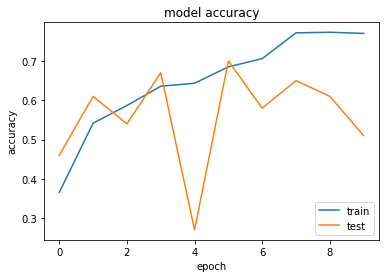

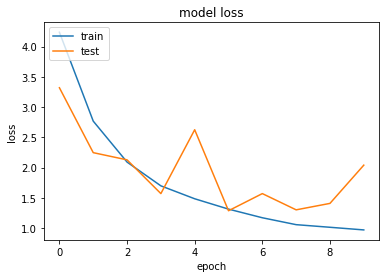

In [12]:
# Model4

# Features
batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,32,5]
dropout = 0.25
nb_classes = 5
frames = 15

# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model.add(Dropout(dropout))

model.add(TimeDistributed(Flatten()))

model.add(Dense(nb_dense[0], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(nb_dense[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(nb_dense[2], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(dropout))

## using LSTM as the RNN model along with softmax as our last layer.
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model4 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

Observation: <br>
1) The training accuracy is 0.7701 where as validation accuracy is 0.5100 <br>
2) We have used LSTM and L2 regularization.

#### Model5 - Transfer Learning + RestNet50 + GRU Layer 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_53 (TimeDis (None, 15, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_54 (TimeDis (None, 15, 4, 4, 2048)    8192      
_________________________________________________________________
time_distributed_55 (TimeDis (None, 15, 2, 2, 2048)    0         
_________________________________________________________________
time_distributed_56 (TimeDis (None, 15, 8192)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                1585344   
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


67/67 [==============================] - 117s 2s/step - loss: 1.5368 - categorical_accuracy: 0.3672 - val_loss: 1.6597 - val_categorical_accuracy: 0.2600

Epoch 00001: saving model to model_init_2020-05-2304_57_41.678187/model-00001-1.53677-0.36716-1.65971-0.26000.h5
Epoch 2/10
67/67 [==============================] - 88s 1s/step - loss: 1.5453 - categorical_accuracy: 0.3567 - val_loss: 1.6524 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_init_2020-05-2304_57_41.678187/model-00002-1.54532-0.35672-1.65243-0.16000.h5
Epoch 3/10
67/67 [==============================] - 88s 1s/step - loss: 1.5795 - categorical_accuracy: 0.3015 - val_loss: 1.6354 - val_categorical_accuracy: 0.2700

Epoch 00003: saving model to model_init_2020-05-2304_57_41.678187/model-00003-1.57947-0.30149-1.63536-0.27000.h5
Epoch 4/10
67/67 [==============================] - 88s 1s/step - loss: 1.7099 - categorical_accuracy: 0.2134 - val_loss: 1.6850 - val_categorical_accuracy: 0.1600

Epoch 00004

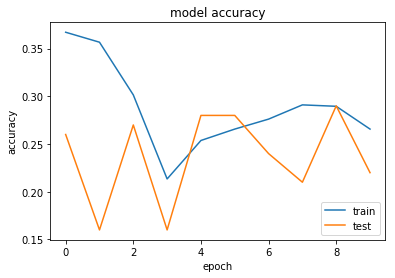

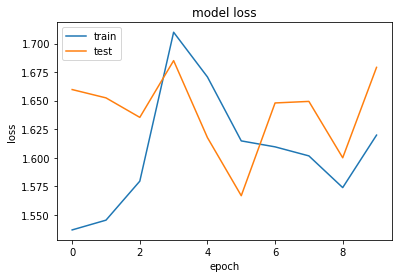

In [13]:
# Model5

# Libraries for ResNet
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, GRU
from keras.models import Model, load_model

batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,32,5]
dropout = 0.25
nb_classes = 5
frames = 15

# Input
input_shape=(frames,120,120,3)

# Get base model: ResNet50 
base_model = ResNet50(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(base_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(nb_dense[1],activation='relu'))
model.add(Dropout(dropout))


model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model5 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

Observation: <br>
1) The training accuracy is 0.2657 where as validation accuracy is 0.2200 <br>
2) We have used transfer learning. Used RestNet50 and GRU

#### Model6 - Transfer Learning + mobilenet + GRU Layer 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_57 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_58 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_59 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_60 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


67/67 [==============================] - 76s 1s/step - loss: 1.3043 - categorical_accuracy: 0.4448 - val_loss: 0.9081 - val_categorical_accuracy: 0.7100

Epoch 00001: saving model to model_init_2020-05-2304_57_41.678187/model-00001-1.30434-0.44478-0.90815-0.71000.h5
Epoch 2/10
67/67 [==============================] - 60s 891ms/step - loss: 0.7245 - categorical_accuracy: 0.7299 - val_loss: 0.7437 - val_categorical_accuracy: 0.7000

Epoch 00002: saving model to model_init_2020-05-2304_57_41.678187/model-00002-0.72449-0.72985-0.74375-0.70000.h5
Epoch 3/10
67/67 [==============================] - 68s 1s/step - loss: 0.5856 - categorical_accuracy: 0.7925 - val_loss: 0.6282 - val_categorical_accuracy: 0.8000

Epoch 00003: saving model to model_init_2020-05-2304_57_41.678187/model-00003-0.58561-0.79254-0.62822-0.80000.h5
Epoch 4/10
67/67 [==============================] - 70s 1s/step - loss: 0.4857 - categorical_accuracy: 0.8522 - val_loss: 0.3868 - val_categorical_accuracy: 0.8900

Epoch 000

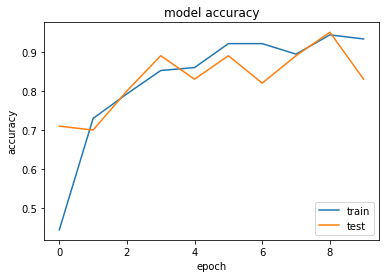

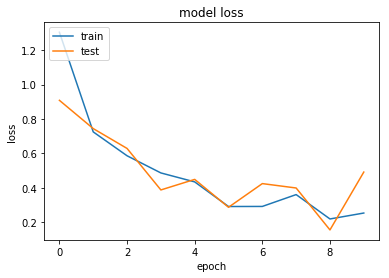

In [14]:
# Model6

# Libraries for mobilenet
from keras.applications import ResNet50, mobilenet
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, GRU
from keras.models import Model, load_model

batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,32,5]
dropout = 0.25
nb_classes = 5
frames = 15

# Input
input_shape=(frames,120,120,3)

# Get base model: mobilenet 
base_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(base_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(nb_dense[1],activation='relu'))
model.add(Dropout(dropout))


model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model6 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

Observation: <br>
1) The training accuracy is 0.9328 where as validation accuracy is 0.8300 <br>
2) We have used transfer learning. Used mobilenet and GRU. Accuracy is good but there is little overfitting.

#### Model7 - Transfer Learning + mobilenet + GRU Layer  + Increased epoch

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_61 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_62 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_63 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_64 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_61 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)                4160      
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


67/67 [==============================] - 77s 1s/step - loss: 1.3500 - categorical_accuracy: 0.4254 - val_loss: 1.1260 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2020-05-2307_03_39.266311/model-00001-1.34998-0.42537-1.12605-0.55000.h5
Epoch 2/15
67/67 [==============================] - 54s 813ms/step - loss: 0.7627 - categorical_accuracy: 0.7179 - val_loss: 0.9257 - val_categorical_accuracy: 0.6600

Epoch 00002: saving model to model_init_2020-05-2307_03_39.266311/model-00002-0.76270-0.71791-0.92570-0.66000.h5
Epoch 3/15
67/67 [==============================] - 65s 965ms/step - loss: 0.4966 - categorical_accuracy: 0.8463 - val_loss: 0.4657 - val_categorical_accuracy: 0.8200

Epoch 00003: saving model to model_init_2020-05-2307_03_39.266311/model-00003-0.49661-0.84627-0.46571-0.82000.h5
Epoch 4/15
67/67 [==============================] - 65s 975ms/step - loss: 0.4531 - categorical_accuracy: 0.8701 - val_loss: 0.5831 - val_categorical_accuracy: 0.8300

Epo

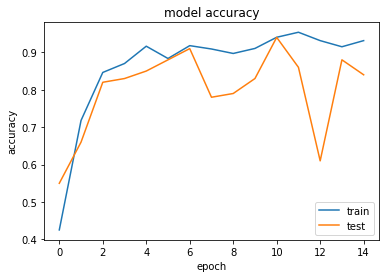

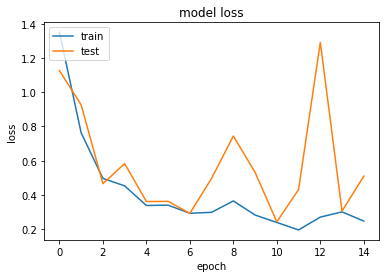

In [23]:
# Model7

# Libraries for mobilenet
from keras.applications import ResNet50, mobilenet
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, GRU
from keras.models import Model, load_model

batch_size = 10 #experiment with the batch size
num_epochs = 15 # choose the number of epochs

nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,32,5]
dropout = 0.25
nb_classes = 5
frames = 15

# Input
input_shape=(frames,120,120,3)

# Get base model: mobilenet 
base_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(base_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(nb_dense[1],activation='relu'))
model.add(Dropout(dropout))


model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model7 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

Observation: <br>
1) The training accuracy is 0.9313 where as validation accuracy is 0.8400 <br>
2) We have used transfer learning. Used mobilenet and GRU. We inccreased the spoch but it did not help with overfitting.

#### Model8 - Transfer Learning + mobilenet + GRU Layer  + Increased epoch + Increase Batch Size

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_73 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_74 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_75 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_76 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_67 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 64)                4160      
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


34/34 [==============================] - 84s 2s/step - loss: 1.3901 - categorical_accuracy: 0.4279 - val_loss: 1.0453 - val_categorical_accuracy: 0.5800

Epoch 00001: saving model to model_init_2020-05-2307_03_39.266311/model-00001-1.39014-0.42794-1.04526-0.58000.h5
Epoch 2/15
34/34 [==============================] - 54s 2s/step - loss: 0.7138 - categorical_accuracy: 0.7500 - val_loss: 0.6508 - val_categorical_accuracy: 0.7400

Epoch 00002: saving model to model_init_2020-05-2307_03_39.266311/model-00002-0.71383-0.75000-0.65075-0.74000.h5
Epoch 3/15
34/34 [==============================] - 70s 2s/step - loss: 0.4586 - categorical_accuracy: 0.8471 - val_loss: 0.7555 - val_categorical_accuracy: 0.7100

Epoch 00003: saving model to model_init_2020-05-2307_03_39.266311/model-00003-0.45860-0.84706-0.75545-0.71000.h5
Epoch 4/15
34/34 [==============================] - 70s 2s/step - loss: 0.2857 - categorical_accuracy: 0.9221 - val_loss: 0.4064 - val_categorical_accuracy: 0.8400

Epoch 00004:

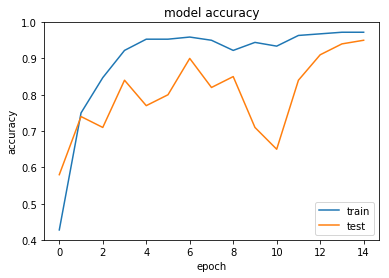

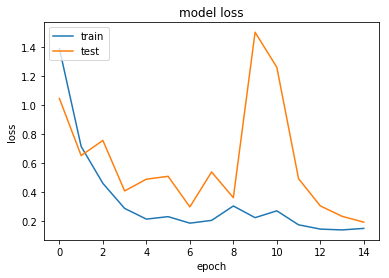

In [26]:
# Model8

# Libraries for mobilenet
from keras.applications import ResNet50, mobilenet
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, GRU
from keras.models import Model, load_model

batch_size = 20 #experiment with the batch size
num_epochs = 15 # choose the number of epochs

nb_featuremap = [16,32,64,128,256]
nb_dense = [128,64,32,5]
dropout = 0.25
nb_classes = 5
frames = 15

# Input
input_shape=(frames,120,120,3)

# Get base model: mobilenet 
base_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(base_model,input_shape=input_shape))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(nb_dense[1],activation='relu'))
model.add(Dropout(dropout))


model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model8 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

Observation: <br>
1) The training accuracy is 0.9721 where as validation accuracy is 0.9500 <br>
2) We have used transfer learning. Used mobilenet and GRU. We increased batchsize.

### Conv3D Model

In [15]:
# Import libraries
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, AveragePooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

#### Model1 - Conv3D layers + BatchNormalization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 120, 120, 8)   200       
_________________________________________________________________
batch_normalization_19 (Batc (None, 15, 120, 120, 8)   32        
_________________________________________________________________
activation_50 (Activation)   (None, 15, 120, 120, 8)   0         
_________________________________________________________________
average_pooling3d_1 (Average (None, 7, 60, 60, 8)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 60, 60, 16)     1040      
_________________________________________________________________
batch_normalization_20 (Batc (None, 7, 60, 60, 16)     64        
_________________________________________________________________
activation_51 (Activation)   (None, 7, 60, 60, 16)     0         
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


67/67 [==============================] - 61s 916ms/step - loss: 1.5947 - categorical_accuracy: 0.2687 - val_loss: 1.4433 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2020-05-2306_07_23.332433/model-00001-1.59467-0.26866-1.44331-0.44000.h5
Epoch 2/15
67/67 [==============================] - 49s 737ms/step - loss: 1.4471 - categorical_accuracy: 0.3328 - val_loss: 1.5345 - val_categorical_accuracy: 0.2400

Epoch 00002: saving model to model_init_2020-05-2306_07_23.332433/model-00002-1.44707-0.33284-1.53447-0.24000.h5
Epoch 3/15
67/67 [==============================] - 59s 875ms/step - loss: 1.3384 - categorical_accuracy: 0.3955 - val_loss: 1.1553 - val_categorical_accuracy: 0.5300

Epoch 00003: saving model to model_init_2020-05-2306_07_23.332433/model-00003-1.33841-0.39552-1.15530-0.53000.h5
Epoch 4/15
67/67 [==============================] - 58s 870ms/step - loss: 1.3000 - categorical_accuracy: 0.3985 - val_loss: 1.2804 - val_categorical_accuracy: 0.4300



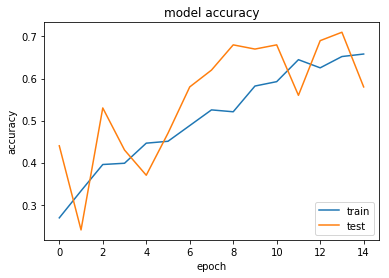

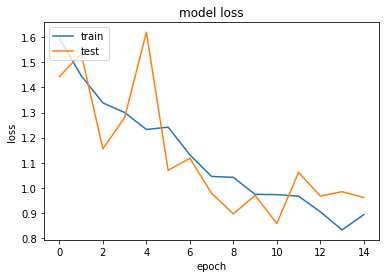

In [16]:
# model1

curr_dt_time = datetime.datetime.now()

batch_size = 10 #experiment with the batch size
num_epochs = 15 # choose the number of epochs

nb_filters = [8,16,32,64]
nb_dense = [32, 32, 5]

kernel = (2,2,2)
# Input
input_shape=(frames,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], kernel_size=kernel, input_shape=input_shape,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.25))
          
model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.25))


#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model1 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

Observation: <br>
1) The training accuracy is 0.6582 where as validation accuracy is 0.5800 <br>
2) We will try dropout on Conv3Dd

#### Model2 - Conv3D layers + Dropout + BatchNormalization + L2 Regularization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 15, 120, 120, 8)   200       
_________________________________________________________________
batch_normalization_22 (Batc (None, 15, 120, 120, 8)   32        
_________________________________________________________________
activation_55 (Activation)   (None, 15, 120, 120, 8)   0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 15, 120, 120, 8)   0         
_________________________________________________________________
average_pooling3d_4 (Average (None, 7, 60, 60, 8)      0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 60, 60, 16)     1040      
_________________________________________________________________
batch_normalization_23 (Batc (None, 7, 60, 60, 16)     64        
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


67/67 [==============================] - 61s 918ms/step - loss: 2.2300 - categorical_accuracy: 0.2448 - val_loss: 1.8747 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_init_2020-05-2306_22_35.137511/model-00001-2.22997-0.24478-1.87467-0.37000.h5
Epoch 2/10
67/67 [==============================] - 45s 679ms/step - loss: 1.8304 - categorical_accuracy: 0.3716 - val_loss: 1.9975 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2020-05-2306_22_35.137511/model-00002-1.83039-0.37164-1.99747-0.23000.h5
Epoch 3/10
67/67 [==============================] - 58s 873ms/step - loss: 1.6839 - categorical_accuracy: 0.4284 - val_loss: 1.6419 - val_categorical_accuracy: 0.4200

Epoch 00003: saving model to model_init_2020-05-2306_22_35.137511/model-00003-1.68393-0.42836-1.64191-0.42000.h5
Epoch 4/10
67/67 [==============================] - 57s 851ms/step - loss: 1.4508 - categorical_accuracy: 0.4776 - val_loss: 1.5641 - val_categorical_accuracy: 0.5200



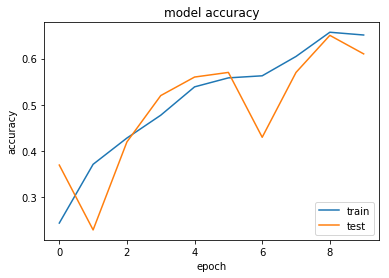

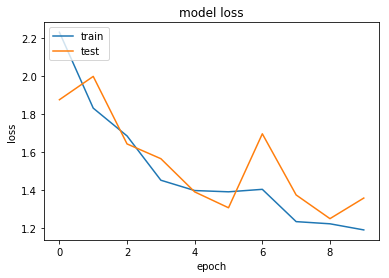

In [17]:
# model2

curr_dt_time = datetime.datetime.now()

batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_filters = [8,16,32,64]
nb_dense = [32, 32, 5]

kernel = (2,2,2)
# Input
input_shape=(frames,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], kernel_size=kernel, input_shape=input_shape,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))
          
model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))


#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model2 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

Observation: <br>
1) The training accuracy is 0.6507 where as validation accuracy is 0.6100 <br>
2) We will try regularization on Conv3Dd

#### Model3 - Conv3D layers + More Layers + Dropout  + L2 Regularization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 15, 120, 120, 8)   200       
_________________________________________________________________
batch_normalization_25 (Batc (None, 15, 120, 120, 8)   32        
_________________________________________________________________
activation_60 (Activation)   (None, 15, 120, 120, 8)   0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 15, 120, 120, 8)   520       
_________________________________________________________________
batch_normalization_26 (Batc (None, 15, 120, 120, 8)   32        
_________________________________________________________________
activation_61 (Activation)   (None, 15, 120, 120, 8)   0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 15, 120, 120, 8)   0         
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


67/67 [==============================] - 70s 1s/step - loss: 2.5867 - categorical_accuracy: 0.2313 - val_loss: 2.3456 - val_categorical_accuracy: 0.1700

Epoch 00001: saving model to model_init_2020-05-2306_32_18.204877/model-00001-2.58668-0.23134-2.34564-0.17000.h5
Epoch 2/10
67/67 [==============================] - 50s 743ms/step - loss: 2.2387 - categorical_accuracy: 0.2015 - val_loss: 2.1327 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model_init_2020-05-2306_32_18.204877/model-00002-2.23871-0.20149-2.13268-0.18000.h5
Epoch 3/10
67/67 [==============================] - 61s 912ms/step - loss: 2.0593 - categorical_accuracy: 0.1836 - val_loss: 1.9838 - val_categorical_accuracy: 0.1800

Epoch 00003: saving model to model_init_2020-05-2306_32_18.204877/model-00003-2.05928-0.18358-1.98383-0.18000.h5
Epoch 4/10
67/67 [==============================] - 63s 934ms/step - loss: 1.9417 - categorical_accuracy: 0.2030 - val_loss: 1.8933 - val_categorical_accuracy: 0.1500

Epo

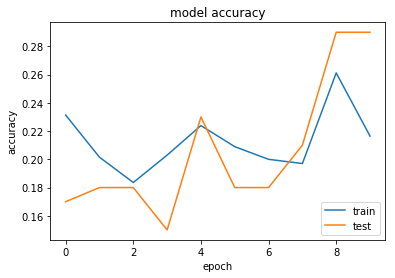

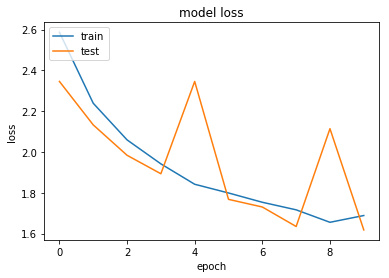

In [18]:
# model3

curr_dt_time = datetime.datetime.now()

batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_filters = [8,16,32,64]
nb_dense = [32, 32, 5]

kernel = (2,2,2)
# Input
input_shape=(frames,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], kernel_size=kernel, input_shape=input_shape,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(nb_filters[0], kernel_size=kernel, input_shape=input_shape,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(nb_filters[1], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(nb_filters[2], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))
          
model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))


#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model3 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

Observation: <br>
1) The training accuracy is 0.2164 where as validation accuracy is 0.2900 <br>
2) We will try more layer for better accuracy

#### Model4 - Conv3D layers + More Layers + Dropout  + L2 Regularization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 15, 120, 120, 8)   200       
_________________________________________________________________
batch_normalization_33 (Batc (None, 15, 120, 120, 8)   32        
_________________________________________________________________
activation_68 (Activation)   (None, 15, 120, 120, 8)   0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 15, 120, 120, 8)   0         
_________________________________________________________________
average_pooling3d_10 (Averag (None, 7, 60, 60, 8)      0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 7, 60, 60, 16)     1040      
_________________________________________________________________
batch_normalization_34 (Batc (None, 7, 60, 60, 16)     64        
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


67/67 [==============================] - 62s 926ms/step - loss: 2.9725 - categorical_accuracy: 0.1955 - val_loss: 2.6473 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2020-05-2306_43_11.906379/model-00001-2.97255-0.19552-2.64730-0.21000.h5
Epoch 2/10
67/67 [==============================] - 53s 787ms/step - loss: 2.4767 - categorical_accuracy: 0.2269 - val_loss: 2.3234 - val_categorical_accuracy: 0.2700

Epoch 00002: saving model to model_init_2020-05-2306_43_11.906379/model-00002-2.47667-0.22687-2.32342-0.27000.h5
Epoch 3/10
67/67 [==============================] - 58s 871ms/step - loss: 2.2278 - categorical_accuracy: 0.2179 - val_loss: 2.1144 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_2020-05-2306_43_11.906379/model-00003-2.22784-0.21791-2.11437-0.21000.h5
Epoch 4/10
67/67 [==============================] - 57s 853ms/step - loss: 2.0636 - categorical_accuracy: 0.2149 - val_loss: 1.9539 - val_categorical_accuracy: 0.2700



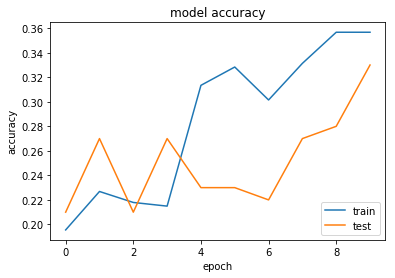

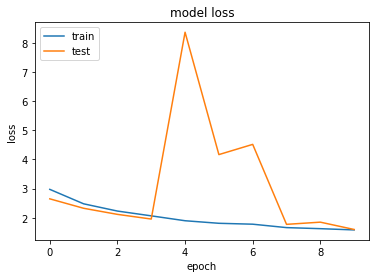

In [19]:
# model4

curr_dt_time = datetime.datetime.now()

batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_filters = [8,16,32,64]
nb_dense = [32, 32, 5]

kernel = (2,2,2)
# Input
input_shape=(frames,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], kernel_size=kernel, input_shape=input_shape,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))
          
model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))

model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))

model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))


#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model4 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

Observation: <br>
1) The training accuracy is 0.3567 where as validation accuracy is 0.3300 <br>
2) We will try more layers and regularization on Conv3Dd

#### Model5 - Conv3D layers + Larger Dense Layer + Dropout  + L2 Regularization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_23 (Conv3D)           (None, 15, 120, 120, 16)  400       
_________________________________________________________________
batch_normalization_37 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
activation_72 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 15, 120, 120, 16)  0         
_________________________________________________________________
average_pooling3d_13 (Averag (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 7, 60, 60, 32)     4128      
_________________________________________________________________
batch_normalization_38 (Batc (None, 7, 60, 60, 32)     128       
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


67/67 [==============================] - 64s 953ms/step - loss: 5.4146 - categorical_accuracy: 0.2642 - val_loss: 3.9336 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_init_2020-05-2306_53_17.308652/model-00001-5.41461-0.26418-3.93361-0.20000.h5
Epoch 2/10
67/67 [==============================] - 51s 768ms/step - loss: 3.3340 - categorical_accuracy: 0.3313 - val_loss: 2.7472 - val_categorical_accuracy: 0.5100

Epoch 00002: saving model to model_init_2020-05-2306_53_17.308652/model-00002-3.33396-0.33134-2.74717-0.51000.h5
Epoch 3/10
67/67 [==============================] - 60s 891ms/step - loss: 2.5814 - categorical_accuracy: 0.4000 - val_loss: 2.2590 - val_categorical_accuracy: 0.5100

Epoch 00003: saving model to model_init_2020-05-2306_53_17.308652/model-00003-2.58137-0.40000-2.25900-0.51000.h5
Epoch 4/10
67/67 [==============================] - 60s 897ms/step - loss: 2.2066 - categorical_accuracy: 0.4194 - val_loss: 2.1811 - val_categorical_accuracy: 0.3800



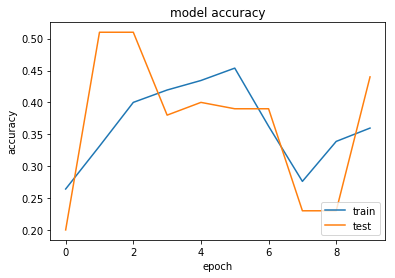

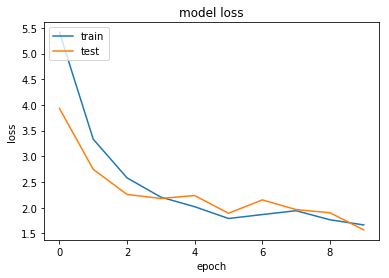

In [20]:
# model5

curr_dt_time = datetime.datetime.now()

batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_filters = [16,32,64,128]
nb_dense = [64, 64, 5]

kernel = (2,2,2)
# Input
input_shape=(frames,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], kernel_size=kernel, input_shape=input_shape,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=l2(0.02)))
model.add(Dropout(0.25))
          
model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=l2(0.02)))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model5 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

Observation: <br>
1) The training accuracy is 0.3597 where as validation accuracy is 0.4400 <br>
2) We will try dropout and deeper network on Conv3Dd

#### Model6 - Conv3D layers + Larger Dense Layer + Dropout  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_27 (Conv3D)           (None, 15, 120, 120, 16)  400       
_________________________________________________________________
batch_normalization_41 (Batc (None, 15, 120, 120, 16)  64        
_________________________________________________________________
activation_76 (Activation)   (None, 15, 120, 120, 16)  0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 15, 120, 120, 16)  0         
_________________________________________________________________
average_pooling3d_16 (Averag (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 7, 60, 60, 32)     4128      
_________________________________________________________________
batch_normalization_42 (Batc (None, 7, 60, 60, 32)     128       
__________

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


67/67 [==============================] - 68s 1s/step - loss: 3.3678 - categorical_accuracy: 0.2224 - val_loss: 1.5199 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-05-2307_03_39.266311/model-00001-3.36775-0.22239-1.51990-0.23000.h5
Epoch 2/10
67/67 [==============================] - 49s 730ms/step - loss: 1.6223 - categorical_accuracy: 0.3164 - val_loss: 1.9469 - val_categorical_accuracy: 0.2700

Epoch 00002: saving model to model_init_2020-05-2307_03_39.266311/model-00002-1.62226-0.31642-1.94690-0.27000.h5
Epoch 3/10
67/67 [==============================] - 60s 890ms/step - loss: 1.4889 - categorical_accuracy: 0.3403 - val_loss: 1.5345 - val_categorical_accuracy: 0.2800

Epoch 00003: saving model to model_init_2020-05-2307_03_39.266311/model-00003-1.48890-0.34030-1.53452-0.28000.h5
Epoch 4/10
67/67 [==============================] - 61s 910ms/step - loss: 1.4014 - categorical_accuracy: 0.4030 - val_loss: 1.4511 - val_categorical_accuracy: 0.3100

Epo

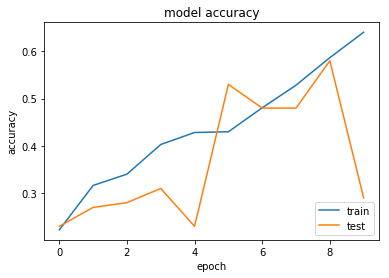

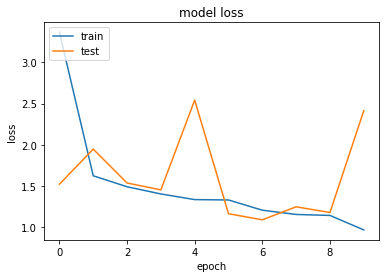

In [21]:
# model6

curr_dt_time = datetime.datetime.now()

batch_size = 10 #experiment with the batch size
num_epochs = 10 # choose the number of epochs

nb_filters = [16,32,64,128]
nb_dense = [256,128,64,5]

kernel = (2,2,2)
# Input
input_shape=(frames,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], kernel_size=kernel, input_shape=input_shape,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(AveragePooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], kernel_size=kernel,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.25))
          
model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_dense[2], activation='relu'))
model.add(Dropout(0.25))
          


#softmax layer
model.add(Dense(nb_dense[3], activation='softmax'))

## Build model
# Definition buildmodel(model,epochsize,batchsize, optimiser, lr)
model6 = buildmodel(model,num_epochs,batch_size,"Adam",0.001)

Observation: <br>
1) The training accuracy is 0.6403 where as validation accuracy is 0.2900 <br>

### Conclusion
1) Handling overfitting is key in such model. Adding batchnormalization, regularization and dropouts help with these <br>
2) Best stable model was achieved with CNN and LSTM combination.The training accuracy is 0.7821 where as validation accuracy is 0.7000 <br>